# L96モデルを用いたデータ同化実験

モデル

$$
\frac{dX_{j}}{dt} = (X_{j+1} - X_{j-2})X_{j-1} - X_{j} + F, 
j=0,...,N-1
$$
周期境界条件、N=40,F=8.0とする

In [1]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import csv

In [2]:
def L96(Xa,F):
    return (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    K1 = h*L96(Xa,F)

    X2=Xa+K1/2
    K2=h*L96(X2,F)
    
    X3=Xa+K2/2
    K3=h*L96(X3,F)
    
    X4=Xa+K3
    K4=h*L96(X4,F)
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

In [3]:
def L96_t(X0,X1,F):
    return (np.roll(X0,-1,axis=0) - np.roll(X0,2,axis=0))*np.roll(X1,1,axis=0) + \
        (np.roll(X1,-1,axis=0) - np.roll(X1,2,axis=0))*np.roll(X0,1,axis=0) - X1

def Rungekutta4_t(X0,X1,h,F):
    K1 = h*L96(X0,F)
    dK1 = h*L96_t(X0,X1,F)
    
    X2 = X0 + K1/2
    dX2 = X1 + dK1/2
    K2 = h*L96(X2,F)
    dK2 = h*L96_t(X2,dX2,F)
    
    X3 = X0 + K2/2
    dX3 = X1 + dK2/2
    K3 = h*L96(X3,F)
    dK3 = h*L96_t(X3,dX3,F)
    
    X4 = X0 + K3
    dX4 = X1 + dK3
    K4 = h*L96(X4,F)
    dK4 = h*L96_t(X4,dX4,F)
    
    dXb = X1 + dK1/6 + dK2/3 + dK3/3 + dK4/6
    
    return dXb

In [4]:
def L96_adj(dXb,X0,F):
    return np.roll(X0,2,axis=0)*np.roll(dXb,1,axis=0) + (np.roll(X0,-2,axis=0) - np.roll(X0,1,axis=0))*np.roll(dXb,-1,axis=0)\
                - np.roll(X0,-1,axis=0)*np.roll(dXb,-2,axis=0) - dXb

def Rungekutta4_adj(dXb,X0,h,F):
    K1 = h*L96(X0,F)
    X2 = X0 + K1/2
    K2 = h*L96(X2,F)
    X3 = X0 + K2/2
    K3 = h*L96(X3,F)
    X4 = X0 + K3
    K4 = h*L96(X4,F)
    
    X1 = dXb
    dK1 = dXb/6
    dK2 = dXb/3
    dK3 = dXb/3
    dK4 = dXb/6
    #print(X1,dK1,dK2,dK3,dK4)
    
    X1 = X1 + h*L96_adj(dK4,X4,F)
    dK1 = dK1
    dK2 = dK2
    dK3 = dK3 + h*L96_adj(dK4,X4,F)
    #print(X1,dK1,dK2,dK3)
    
    X1 = X1 + h*L96_adj(dK3,X3,F)
    dK1 = dK1
    dK2 = dK2 + h*L96_adj(dK3,X3,F)/2
    #print(X1,dK1,dK2)
    
    X1 = X1 + h*L96_adj(dK2,X2,F)
    dK1 = dK1 + h*L96_adj(dK2,X2,F)/2
    #print(X1,dK1)
    
    X1 = X1 + h*L96_adj(dK1,X0,F)
    #print(X1)
    
    return X1

## 接線形とアジョイントのチェック

In [5]:
N=40
m=10
h=0.05
F=8.0
X1 = np.random.rand(N)
X0 = np.ones(N)
Ax = Rungekutta4_t(X0,X1,h,F)
AtAx = Rungekutta4_adj(Ax,X0,h,F)
a = Ax.T@Ax
b = X1.T@AtAx
print(a);print(b)
print(a-b)

10.88789951228063
10.887899512280631
-1.7763568394002505e-15


## 定常解の周りの安定性
定常解$X_j=F$に摂動を与えたときの安定性について

$X_j = F+x_j, \quad \|x_j\| \ll F$として、$x_j$に対して線形化
$$
\frac{dx_j}{dt} = (x_{j+1}-x_{j-2})F-x_j
$$
$x_j=\sum_{k}p_k\exp(ikj)$とおいて代入すると、
$$
\frac{dp_k}{dt}=[(e^{ik}-e^{-i2k})F-1]p_k\\
\Rightarrow p_k(t)=p_k(0)\exp(\lambda_k t)\\
\lambda_k = \{(\cos k - \cos 2k)-1/F\}F + i(\sin k + \sin 2k)F
$$
$(\cos k - \cos 2k)-1/F$が正のとき不安定となる。

[ 0.00000000e+00  5.90055838e-02  2.24354285e-01  4.62977860e-01
  7.25906232e-01  9.56449142e-01  1.09975147e+00  1.11218948e+00
  9.69095253e-01  6.69556322e-01  2.37496784e-01 -2.81168247e-01
 -8.24892699e-01 -1.32540542e+00 -1.71778822e+00 -1.95016278e+00
 -1.99147969e+00 -1.83619568e+00 -1.50510973e+00 -1.04222755e+00
 -5.08143587e-01  2.90278328e-02  5.03760144e-01  8.62691094e-01
  1.07218684e+00  1.12273371e+00  1.02950093e+00  8.29022782e-01
  5.72561015e-01  3.17229887e-01  1.16316328e-01  1.03497947e-02
  2.03523531e-02  1.44348634e-01  3.57693498e-01  6.17165036e-01
  8.68168671e-01  1.05389981e+00  1.12499683e+00  1.04813305e+00
  8.12159447e-01  4.30793100e-01 -5.86100667e-02 -6.00041853e-01
 -1.12683677e+00 -1.57144697e+00 -1.87548379e+00 -1.99846540e+00
 -1.92390820e+00 -1.66181237e+00 -1.24715359e+00 -7.34616495e-01
 -1.90390932e-01  3.17690767e-01  7.30141868e-01  1.00438652e+00
  1.12058291e+00  1.08382074e+00  9.22383423e-01  6.82386565e-01
  4.19674951e-01  1.90290

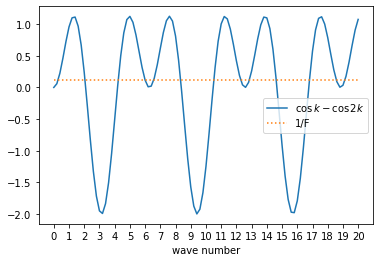

In [16]:
# stability
k = np.linspace(0,N/2,101)
lam = (np.cos(k) - np.cos(2.0*k))
y = np.ones(k.size)/F
print(lam)
plt.plot(k, lam, label=r"$\cos{k} - \cos{2k}$")
plt.plot(k,y,linestyle="dotted",label="1/F")
plt.xlabel("wave number")
plt.legend()
plt.xticks(k[::5])
plt.savefig("stability_l96_F={}.png".format(int(F)))
plt.show()

## Kaiman filter
forecast

$
x^{a} = x^{b} + K(y^{o}-Hx^{b})
$

$
P_{b} = MP_{a}M^{T}
$

analysis

$
K = P_{b}H^{T}(R+HP_{b}H^{T})^{-1}
$

$
P_{a} = (I-KH)P_{b}
$

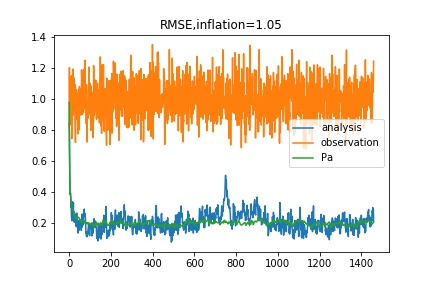

In [4]:
from IPython.display import Image
Image("./KFrmse.jpg")

## 3DVar
cost function
$
J(x) = \frac{1}{2}(x-x^{b})^{T}B^{-1}(x-x^{b}) + \frac{1}{2}(y^{o}-Hx^{b})^{T}R^{-1}(y^{o}-Hx^{b})
$

$
x^{a} = x^{b} + (B^{-1} + H^{T}R^{-1}H)^{-1}H^{T}R^{-1}(y^{o}-Hx^{b})
$

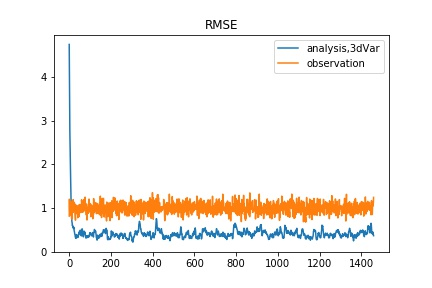

In [10]:
Image("3dvar.jpg")

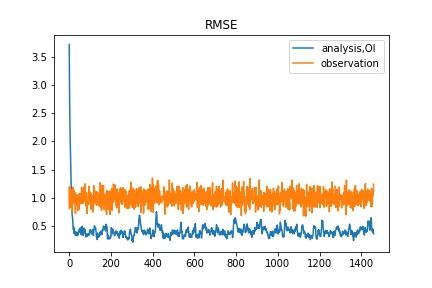

In [11]:
Image("OI.jpg")